In [1]:
%load_ext autoreload
%autoreload 2

# Quantum Phase Estimation - Qubitization

In this notebook, we'll show how to perform quantum phase estimation (QPE) on the qubitized walk operator of a LOBE circuit. 
Estimating the eigenphase of the qubitized walk operator will allow us to determine the eigenvalues of the original operator.  

In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../Reinterpreting-QPE'))
from src.lobe.qubitization import add_qubitized_walk_operator
from src.lobe.rescale import bosonically_rescale_terms, get_numbers_of_bosonic_operators_in_terms
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.system import System
from src.lobe._utils import get_basis_of_full_system, pretty_print
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np
from openparticle import ParticleOperator, generate_matrix
from postprocess import add_inv_qft, get_initial_state, get_probabilities_of_phase_register, plot_probabilities
from windows import add_rectangular_window

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-18 10:53:40,634	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def add_phase_kickback_of_qubitization_iterate(phase_register, terms, coefficients, validation, clean_ancillae_register, rotation_register, index_register, system):
    """Assumes qubits are ordered from LSB to MSB"""
    gates = []
    for i, qubit in enumerate(phase_register):
        for _ in range(1 << i):
            gates += add_qubitized_walk_operator(terms, coefficients, validation, clean_ancillae_register, rotation_register, index_register, system, ctrls=([qubit], [1]))
    return gates

In [4]:
terms = [
    0.25 * ParticleOperator("a0^ a0"),
    -0.5 * ParticleOperator("a0^"),
    # -0.5 * ParticleOperator("a0"),
]

operator = terms[0]
for term in terms[1:]:
    operator += term

maximum_occupation_number = 1
rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(
    terms, maximum_occupation_number
)
rescaled_coefficients = [term.coeff for term in rescaled_terms]
norm = sum(np.abs(rescaled_coefficients))
target_state = get_target_state(rescaled_coefficients)

max_number_of_bosonic_ops_in_term = max(
    get_numbers_of_bosonic_operators_in_terms(terms)
)
number_of_modes = max([term.max_mode() for term in terms]) + 1

full_fock_basis = get_basis_of_full_system(
    number_of_modes,
    maximum_occupation_number,
    has_fermions=operator.has_fermions,
    has_antifermions=operator.has_antifermions,
    has_bosons=operator.has_bosons,
)
matrix = generate_matrix(operator, full_fock_basis)
evals, evecs = np.linalg.eig(matrix / (bosonic_rescaling_factor * norm))
print(evals)

[0.20710678+0.j 0.        +0.j]


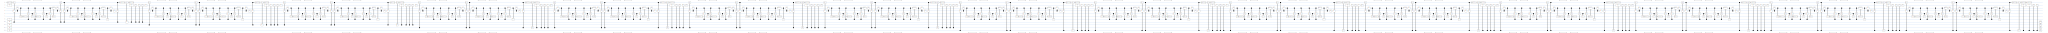

In [5]:
bits_of_precision = 4
simulator = cirq.Simulator()
circuit = cirq.Circuit()
number_of_ancillae = 5
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = max_number_of_bosonic_ops_in_term

# Declare Qubits
circuit = cirq.Circuit()
index_register = [
    cirq.LineQubit(i)
    for i in range(number_of_index_qubits)
]
validation = cirq.LineQubit(number_of_index_qubits)
clean_ancillae = [cirq.LineQubit(i + 1 + number_of_index_qubits) for i in range(number_of_ancillae)]
rotation_qubits = [
    cirq.LineQubit(i + 1 + number_of_ancillae + number_of_index_qubits)
    for i in range(number_of_rotation_qubits)
]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=1
    + number_of_ancillae
    + number_of_rotation_qubits
    + number_of_index_qubits,
    has_fermions=operator.has_fermions,
    has_antifermions=operator.has_antifermions,
    has_bosons=operator.has_bosons,
)
phase_register = [cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits + number_of_index_qubits + system.number_of_system_qubits) for i in range(bits_of_precision)]
circuit.append(cirq.I.on_each(*system.fermionic_register))
circuit.append(cirq.I.on_each(*system.antifermionic_register))
for bosonic_reg in system.bosonic_system:
    circuit.append(cirq.I.on_each(*bosonic_reg))
    
# circuit.append(cirq.X.on(validation))
circuit += add_prepare_circuit(index_register, target_state=target_state)
circuit += add_rectangular_window(phase_register)
circuit += add_phase_kickback_of_qubitization_iterate(phase_register, terms, rescaled_coefficients, validation, clean_ancillae, rotation_qubits, index_register, system)
circuit += add_prepare_circuit(index_register, target_state=target_state, dagger=True)
circuit += add_inv_qft(phase_register)

number_of_used_ancillae = len(circuit.all_qubits())
number_of_used_ancillae -= (
    1
    + number_of_rotation_qubits
    + number_of_index_qubits
    + system.number_of_system_qubits
    + bits_of_precision
)

SVGCircuit(circuit)

In [6]:
[number_of_index_qubits, 1, number_of_used_ancillae, number_of_rotation_qubits, system.number_of_system_qubits, bits_of_precision]

[1, 1, 2, 2, 1, 4]

(1+0j)           |1>

(1+0j)           |0|1|00|00|1|0000>

(-0.259+0j)      |0|0|00|00|0|0000>
(0.09+0.118j)    |0|0|00|00|0|0001>
(0.098+0.053j)   |0|0|00|00|0|0010>
(-0.07-0.024j)   |0|0|00|00|0|0011>
(-0.003+0.001j)  |0|0|00|00|0|0100>
(-0.02+0.009j)   |0|0|00|00|0|0101>
(0.039+0.099j)   |0|0|00|00|0|0110>
(-0-0.027j)      |0|0|00|00|0|0111>
(-0.008+0j)      |0|0|00|00|0|1000>
(-0+0.027j)      |0|0|00|00|0|1001>
(0.039-0.099j)   |0|0|00|00|0|1010>
(-0.02-0.009j)   |0|0|00|00|0|1011>
(-0.003-0.001j)  |0|0|00|00|0|1100>
(-0.07+0.024j)   |0|0|00|00|0|1101>
(0.098-0.053j)   |0|0|00|00|0|1110>
(0.09-0.118j)    |0|0|00|00|0|1111>
(0.359+0j)       |0|0|00|00|1|0000>
(0.139-0.022j)   |0|0|00|00|1|0001>
(0.063+0.077j)   |0|0|00|00|1|0010>
(-0.021-0.105j)  |0|0|00|00|1|0011>
(0.002-0.024j)   |0|0|00|00|1|0100>
(0.002-0.005j)   |0|0|00|00|1|0101>
(0.03+0.08j)     |0|0|00|00|1|0110>
(0.078-0.039j)   |0|0|00|00|1|0111>
(0.054+0j)       |0|0|00|00|1|1000>
(0.078+0.039j)   |0|0|00|00|1|1001>
(0.03

/Users/williamsimon/Desktop/Research/SparseOracle/lobe/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


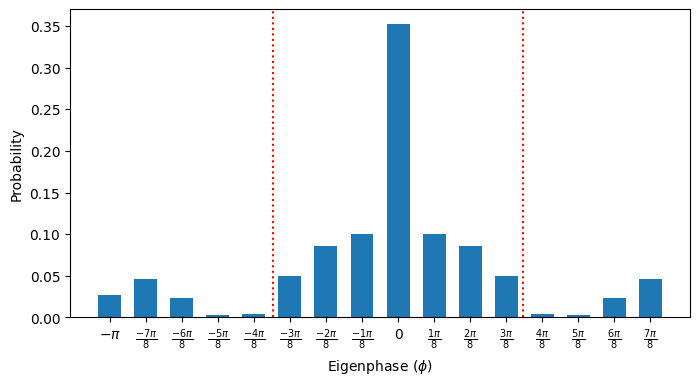

In [7]:
excitation_level = 0
print(pretty_print(evecs[:, excitation_level], [system.number_of_system_qubits]))

# one_state = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
one_state = np.array([0, 1])
initial_state = get_initial_state(number_of_index_qubits, one_state, 0)
initial_state = np.kron(
    initial_state,
    get_initial_state(number_of_used_ancillae + number_of_rotation_qubits, evecs[:, excitation_level], bits_of_precision)
)
print(pretty_print(initial_state, [number_of_index_qubits, 1, number_of_used_ancillae, number_of_rotation_qubits, system.number_of_system_qubits, bits_of_precision]))

frequency_state = simulator.simulate(circuit, initial_state=initial_state).final_state_vector
print(pretty_print(frequency_state, [number_of_index_qubits, 1, number_of_used_ancillae, number_of_rotation_qubits, system.number_of_system_qubits, bits_of_precision]))
probabilities = get_probabilities_of_phase_register(frequency_state, bits_of_precision)
plot_probabilities(probabilities, qubitization=True, vlines=[np.arccos(evals[excitation_level]), -1*np.arccos(evals[excitation_level])])

In [8]:
np.arccos(evals[excitation_level])

(1.362179636485748-0j)

# Debugging

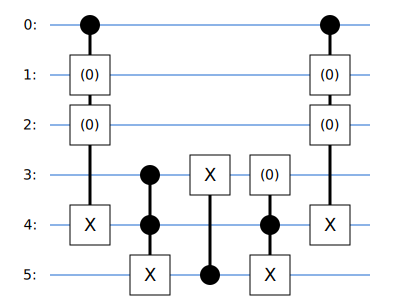

In [280]:
circuit = cirq.Circuit()

ctrl = cirq.LineQubit(0)
index = [cirq.LineQubit(1), cirq.LineQubit(2)]
valid = cirq.LineQubit(3)
ancillae = [cirq.LineQubit(4), cirq.LineQubit(5)]

circuit.append(cirq.X.on(ancillae[0]).controlled_by(ctrl, *index, control_values=[1, 0, 0]))
circuit.append(cirq.X.on(ancillae[1]).controlled_by(valid, ancillae[0], control_values=[1, 1]))

circuit.append(cirq.X.on(valid).controlled_by(ancillae[1]))

circuit.append(cirq.X.on(ancillae[1]).controlled_by(valid, ancillae[0], control_values=[0, 1]))
circuit.append(cirq.X.on(ancillae[0]).controlled_by(ctrl, *index, control_values=[1, 0, 0]))

SVGCircuit(circuit)

In [283]:
zero_state = [1, 0]
one_state = [0, 1]
had_state = [1/np.sqrt(2), 1/np.sqrt(2)]

ctrl_state = one_state
index_state = np.kron(had_state, had_state)
valid_state = zero_state
ancillae_state = np.kron(zero_state, zero_state)

initial_state = np.kron(
    np.kron(
        np.kron(ctrl_state, index_state),
        valid_state
    ),
    ancillae_state
)
print(pretty_print(initial_state, [1, 2, 1, 1, 1]))

final_state = simulator.simulate(circuit, initial_state=initial_state).final_state_vector
print(pretty_print(final_state, [1, 2, 1, 1, 1]))


0.5              |1|00|0|0|0>
0.5              |1|01|0|0|0>
0.5              |1|10|0|0|0>
0.5              |1|11|0|0|0>

(0.5+0j)         |1|00|0|0|1>
(0.5+0j)         |1|01|0|0|0>
(0.5+0j)         |1|10|0|0|0>
(0.5+0j)         |1|11|0|0|0>



In [376]:
zero_state = [1, 0]
one_state = [0, 1]
had_state = [1/np.sqrt(2), 1/np.sqrt(2)]

ctrl_state = one_state
index_state = np.kron(had_state, had_state)
valid_state = had_state
ancillae_state = np.kron(zero_state, zero_state)

initial_state = np.kron(
    np.kron(
        np.kron(ctrl_state, index_state),
        valid_state
    ),
    ancillae_state
)
print(pretty_print(initial_state, [1, 2, 1, 1, 1]))

circuit = cirq.Circuit()

ctrl = cirq.LineQubit(0)
index = [cirq.LineQubit(1), cirq.LineQubit(2)]
valid = cirq.LineQubit(3)
ancillae = [cirq.LineQubit(4), cirq.LineQubit(5)]

circuit.append(cirq.X.on(ancillae[0]).controlled_by(ctrl, *index, control_values=[1, 0, 0]))
circuit.append(cirq.X.on(ancillae[1]).controlled_by(valid, ancillae[0], control_values=[1, 1]))

circuit.append(cirq.X.on(valid).controlled_by(ancillae[1]))

circuit.append(cirq.H.on(ancillae[1]))
circuit.append(cirq.measure(ancillae[1]))

simulation = simulator.simulate(circuit, initial_state=initial_state)

end_circuit = cirq.Circuit()
end_circuit.append(cirq.I.on_each(ctrl, *index, valid, *ancillae))
if simulation.measurements["q(5)"][0] == 1:
    end_circuit.append(cirq.Z.on(ancillae[0]).controlled_by(valid, control_values=[1]))
    end_circuit.append(cirq.X.on(ancillae[1]))
end_circuit.append(cirq.X.on(ancillae[0]).controlled_by(ctrl, *index, control_values=[1, 0, 0]))

final_state = simulator.simulate(end_circuit, initial_state=simulation.final_state_vector).final_state_vector

print(pretty_print(final_state, [1, 2, 1, 1, 1]))

0.354            |1|00|0|0|0>
0.354            |1|00|1|0|0>
0.354            |1|01|0|0|0>
0.354            |1|01|1|0|0>
0.354            |1|10|0|0|0>
0.354            |1|10|1|0|0>
0.354            |1|11|0|0|0>
0.354            |1|11|1|0|0>

(0.632+0j)       |1|00|0|0|0>
(0.316+0j)       |1|01|0|0|0>
(0.316+0j)       |1|01|1|0|0>
(0.316+0j)       |1|10|0|0|0>
(0.316+0j)       |1|10|1|0|0>
(0.316+0j)       |1|11|0|0|0>
(0.316+0j)       |1|11|1|0|0>



In [323]:
(0.408+0j)       |1|01|0|0|0>
(0.408+0j)       |1|01|1|0|0>
(0.408+0j)       |1|10|0|0|0>
(0.408+0j)       |1|10|1|0|0>
(0.408+0j)       |1|11|0|0|0>
(0.408+0j)       |1|11|1|0|0>

0

In [316]:


final_state = simulator.simulate(circuit, initial_state=initial_state).final_state_vector
print(pretty_print(final_state, [1, 2, 1, 1, 1]))

0.5              |1|00|0|0|0>
0.5              |1|01|0|0|0>
0.5              |1|10|0|0|0>
0.5              |1|11|0|0|0>

(1+0j)           |1|00|0|0|1>



In [41]:
from src.lobe.usp import add_naive_usp
from src.lobe.block_encoding import add_lobe_oracle
from src.lobe.rescale import rescale_terms_usp


n_terms = 2
max_mode = 1
max_len_of_terms = 2
operator = ParticleOperator.random(
["boson"],
n_terms,
max_mode=max_mode,
max_len_of_terms=4,
complex_coeffs=False,
normal_order=True,
).normal_order()
operator.remove_identity()
maximum_occupation_number = 1


terms = operator.to_list()[:2]

print(terms)

hamiltonian = terms[0]
for term in terms[1:]:
    hamiltonian += term

number_of_modes = max([term.max_mode() for term in terms]) + 1

rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(
    terms, maximum_occupation_number
)
rescaled_terms, usp_rescaling_factor = rescale_terms_usp(rescaled_terms)

number_of_ancillae = 100
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = (
    max(get_numbers_of_bosonic_operators_in_terms(terms)) + 1
)

rescaling_factor = (
    (1 << number_of_index_qubits) * bosonic_rescaling_factor * usp_rescaling_factor
)

# Declare Qubits
circuit = cirq.Circuit()
validation = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
rotation_qubits = [
    cirq.LineQubit(i + 1 + number_of_ancillae)
    for i in range(number_of_rotation_qubits)
]
index_register = [
    cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
    for i in range(number_of_index_qubits)
]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=1
    + number_of_ancillae
    + number_of_rotation_qubits
    + number_of_index_qubits,
    has_fermions=hamiltonian.has_fermions,
    has_antifermions=hamiltonian.has_antifermions,
    has_bosons=hamiltonian.has_bosons,
)
circuit.append(
    cirq.I.on_each(
        validation,
        *rotation_qubits,
        *index_register,
        *system.fermionic_register,
        *system.antifermionic_register,
    )
)
for bosonic_reg in system.bosonic_system:
    circuit.append(cirq.I.on_each(*bosonic_reg))

if len(circuit.all_qubits()) >= 32:
    raise RuntimeError()

# Generate full Block-Encoding circuit
circuit.append(cirq.X.on(validation))
circuit.append(cirq.X.on(validation))
circuit += add_naive_usp(index_register)
circuit += add_lobe_oracle(
    rescaled_terms,
    validation,
    index_register,
    system,
    rotation_qubits,
    clean_ancillae,
    perform_coefficient_oracle=True,
    decompose=True,
)
circuit += add_naive_usp(index_register)

if len(circuit.all_qubits()) >= 14:
    raise RuntimeError()
else:
    full_fock_basis = get_basis_of_full_system(
        number_of_modes,
        maximum_occupation_number,
        has_fermions=hamiltonian.has_fermions,
        has_antifermions=hamiltonian.has_antifermions,
        has_bosons=hamiltonian.has_bosons,
    )
    matrix = generate_matrix(hamiltonian, full_fock_basis)

    upper_left_block = circuit.unitary(dtype=complex)[
        : 1 << system.number_of_system_qubits, : 1 << system.number_of_system_qubits
    ]

    assert np.allclose(upper_left_block * rescaling_factor, matrix)

[(-81.84254169300414+0j) * a0^ a0
, (-81.84254169300414+0j) * a0^ a0^ a0 a0
]


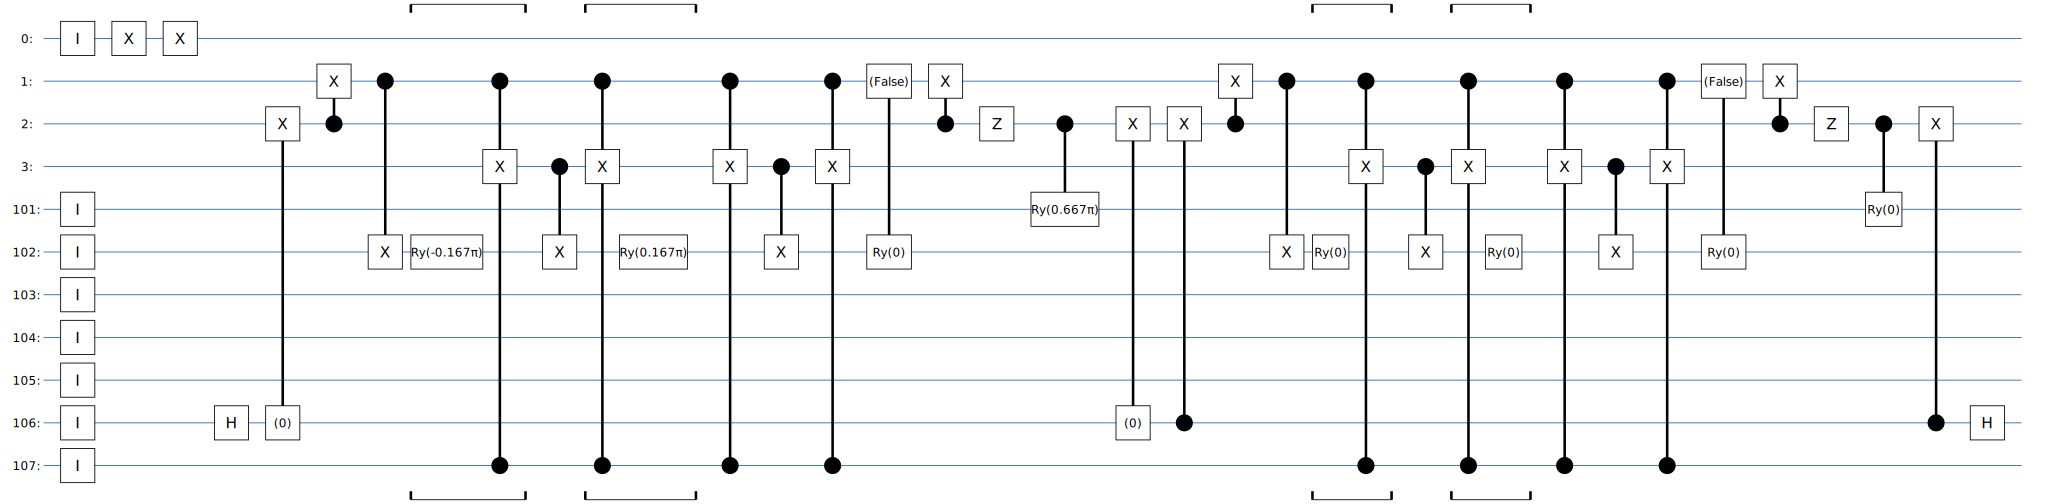

In [42]:
SVGCircuit(circuit)

In [404]:
terms

[0.25 * a0^ a0, -0.5 * a0^]